In [18]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import os, certifi
from mtp.mheads._abc import AbstractDisributionHeadConfig
from mtp.mheads import MHEADS
os.environ["SSL_CERT_FILE"] = certifi.where()

In [19]:
import torch, torch.nn.functional as F, matplotlib.pyplot as plt
from IPython.display import display, update_display, HTML

def qual_eval(model, handle=None, digit=0, shape=(28,28), clear=False, px=120):
    if not hasattr(qual_eval, "_store"): qual_eval._store = {}
    if clear and handle is not None:
        update_display(HTML(""), display_id=handle.display_id)
        qual_eval._store.pop(handle.display_id, None); return handle

    dev = next(model.parameters()).device
    with torch.no_grad():
        z = F.one_hot(torch.tensor([digit], device=dev), num_classes=10).float()
        img = model.generate(z)[0].detach().cpu().view(*shape).numpy()

    new = handle is None or getattr(handle, "display_id", None) not in qual_eval._store
    if new:
        dpi = 100
        fig, ax = plt.subplots(figsize=(px/dpi, px/dpi), dpi=dpi)
        im = ax.imshow(img, cmap="gray", interpolation="nearest")
        ax.axis("off"); fig.subplots_adjust(0,0,1,1)
        handle = display(fig, display_id=True); plt.close(fig)
        qual_eval._store[handle.display_id] = (im, fig)
    else:
        im, fig = qual_eval._store[handle.display_id]
        im.set_data(img)
        # resize if px changed
        fig.set_size_inches(px/fig.dpi, px/fig.dpi)
        update_display(fig, display_id=handle.display_id)
    return handle


In [20]:
# Make the image binary: threshold at 0.5 after ToTensor, then convert to long (int)
transform = transforms.Compose([transforms.ToTensor(), lambda x: (x > 0.5).long()])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.MNIST(
    "./data", train=True, transform=transform, download=True
)
validation_set = torchvision.datasets.MNIST(
    "./data", train=False, transform=transform, download=True
)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=4, shuffle=False
)

# Report split sizes
print("Training set has {} instances".format(len(training_set)))
print("Validation set has {} instances".format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


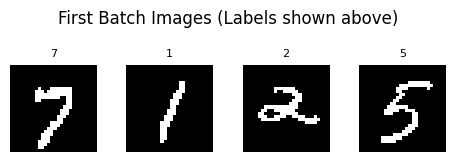

In [21]:
# Get the first batch from the training loader
dataiter = iter(training_loader)
images, labels = next(dataiter)

# Show up to the first 10 images in the batch using seaborn
num_images = min(10, images.shape[0])
plt.figure(figsize=(num_images * 1.2, 1.5))  # Make images smaller

for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    img = images[i].squeeze().numpy()
    sns.heatmap(img, cmap='gray', cbar=False, xticklabels=False, yticklabels=False, square=True)
    plt.title(f"{labels[i].item()}", fontsize=8)
    plt.axis('off')

plt.suptitle("First Batch Images (Labels shown above)", y=1.05)
plt.tight_layout()
plt.show()


  0%|          | 0/15000 [00:00<?, ?it/s, loss=0.936]

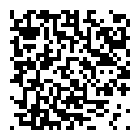

  6%|▋         | 974/15000 [13:57<3:21:02,  1.16it/s, loss=0.254]


KeyboardInterrupt: 

In [22]:
# HPs
num_epochs = 5
lr = 0.001  

model = MHEADS["moe_proj"](
    AbstractDisributionHeadConfig(
        horizon=784,
        d_model=10,  # 9 digits
        d_output=2,  # 2 classes
        rank=32,
        pos_func='abs',
    )
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
h=None
for epoch in range(num_epochs):
    pbar = tqdm(training_loader)
    model.train()
    for batch in pbar:
        y, x = batch  # for gen modelling reverse x, y
        B = x.shape[0]
        z = (
            torch.nn.functional.one_hot(
                x,
                num_classes=10,
            )
            .reshape(B, -1)
            .to(torch.float32)
        )  # (B, 10)
        z, y = z.to(device), y.to(device)
        output = model(z, y.reshape(B, -1))
        loss = output.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        pbar.set_postfix(loss=loss.item())
        # Sample
        h = qual_eval(model, h, digit=0)   # reuse same output cell
    print(f"Epoch {epoch+1} | Loss: {loss.item()}")


    

In [29]:
# Sample
qual_eval(model, h, digit=0)

<DisplayHandle display_id=ad7f61317a3349a004928072b23f404b>